## Importing

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

import random
random.seed(42)

## Formatting the data

In [2]:
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [3]:
len(words)

32033

In [4]:
# build the mapping of each letter

abc = '.abcdefghijklmnopqrstuvwxyz'
vocab_size = len(abc)

stoi = {s: i for i, s in enumerate(abc)}
# stoi['.'] = 0
itos = {i: s for s, i in stoi.items()}

In [70]:
block_size = 3

# build the databse
def build_dataset(words):
    X, Y = [], []
    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]
    
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

# training, dev and test split
# 80%   10%   10%
Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182383, 3]) torch.Size([182383])
torch.Size([22907, 3]) torch.Size([22907])
torch.Size([22856, 3]) torch.Size([22856])


## Classes

In [84]:
# Classes (or modules) for all the operations

class Linear:
    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out), generator=g) / fan_in**0.5    # * 5/3 * ((n_embd * block_size)**0.5)
        self.bias = torch.zeros(fan_out) if bias else None

    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out

    def parameters(self):
        return [self.weight] + ([self.bias] if self.bias is not None else [])


class BatchNorm1D:
    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        # Parameters (trained with backprop)
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        # Buffers (trained with a running 'momentum update')
        self.running_mean = torch.zeros((1, dim))
        self.running_var = torch.ones((1, dim))    # variance

    def __call__(self, x):
        # Calculate the forward pass
        if self.training:
            xmean = x.mean(0, keepdim=True)
            xvar = x.var(0, keepdim=True)
        else:
            xmean = self.running_mean
            xvar = self.running_var
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps)    # normalise to unit variance
        self.out = self.gamma * xhat + self.beta
        # Update the buffers
        if self.training:
            with torch.no_grad():
                # self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                # self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
                self.running_mean += self.momentum * (-self.running_mean + xmean)
                self.running_var += self.momentum * (xvar - self.running_var)
                # assert 0>1
        return self.out
    
    def parameters(self):
        return [self.gamma, self.beta]


class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out

    def parameters(self):
        return []


## Training NN

In [101]:
# Initialising the NN
n_embd = 10    # the dimensionality of the character embedding vector
n_hidden = 100    # the number of neurons in the hidden layer of MLP
g = torch.Generator().manual_seed(2147483647)    # for reproducibility

C = torch.randn((vocab_size, n_embd), generator=g)
Layers = [
    Linear(n_embd * block_size, n_hidden), BatchNorm1D(n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden), BatchNorm1D(n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden), BatchNorm1D(n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden), BatchNorm1D(n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden), BatchNorm1D(n_hidden), Tanh(),
    Linear(           n_hidden, vocab_size), BatchNorm1D(vocab_size),
]

# Layers = [
#     Linear(n_embd * block_size, n_hidden), Tanh(),
#     Linear(           n_hidden, n_hidden), Tanh(),
#     Linear(           n_hidden, n_hidden), Tanh(),
#     Linear(           n_hidden, n_hidden), Tanh(),
#     Linear(           n_hidden, n_hidden), Tanh(),
#     Linear(           n_hidden, vocab_size),
# ]

with torch.no_grad():
    # make last layer less confident
    # Layers[-1].weight *= 0.1
    Layers[-1].gamma *= 0.1    # last layer is a BN now
    # apply gain to all other layers
    for layer in Layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 5/3

parameters = [C] + [p for layer in Layers for p in layer.parameters()]
# [print(p) for layer in Layers for p in layer.parameters()]
print('We have', sum([p.nelement() for p in parameters]), 'number of parameters!')
for p in parameters:
    p.requires_grad = True

We have 47551 number of parameters!


In [102]:
max_steps = 2_00_000
batch_size = 32
lossi = []
ud = []

for i in range(max_steps):
    # Construct Minibatch
    ix = torch.randint(0, Xtr.shape[0], (batch_size, ), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]    # Batch X, Y

    # Forward Pass
    emb = C[Xb]    # Embed the chars into vectors
    x = emb.view(emb.shape[0], -1)    # concatenates the vectors
    for layer in Layers:
        x = layer(x)
    loss = F.cross_entropy(x, Yb)    # loss function
    
    # Backward Pass
    for layer in Layers:
        layer.out.retain_grad()
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # Update
    lr = 0.1 if i < 100_000 else 0.01
    for p in parameters:
        p.data -= lr * p.grad

    # track stats
    if i % 10000 == 0:    # print every once in a while
        print(f'{i:7d} / {max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    with torch.no_grad():
        ud.append([(lr*p.grad.std() / p.data.std()).log10().item() for p in parameters])

    if i >= 1000:
        break
print('Done')

      0 /  200000: 3.3222
Done


## Visualising

layer 2 (      Tanh): mean -0.01, std 0.63, saturated 3.00%
layer 5 (      Tanh): mean -0.00, std 0.64, saturated 2.56%
layer 8 (      Tanh): mean -0.01, std 0.64, saturated 1.81%
layer 11 (      Tanh): mean -0.00, std 0.64, saturated 2.16%
layer 14 (      Tanh): mean -0.00, std 0.64, saturated 2.41%


Text(0.5, 1.0, 'Activation Distribution')

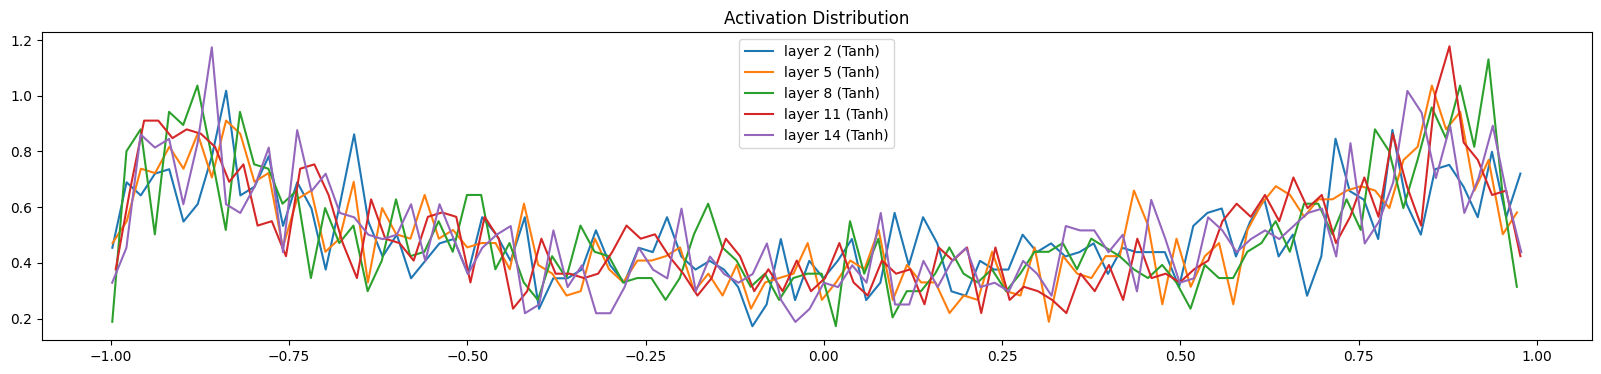

In [103]:
# Forward Pass visualization
plt.figure(figsize=(20, 4))
legends = []
for i, layer in enumerate(Layers[:-1]):    # excludes the output layer
    if isinstance(layer, Tanh):
        t = layer.out
        print('layer %d (%10s): mean %+.2f, std %.2f, saturated %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__})')
plt.legend(legends);
plt.title('Activation Distribution')

layer 2 (      Tanh): mean +0.000000, std 3.310382e-03
layer 5 (      Tanh): mean +0.000000, std 2.796314e-03
layer 8 (      Tanh): mean +0.000000, std 2.623597e-03
layer 11 (      Tanh): mean -0.000000, std 2.350987e-03
layer 14 (      Tanh): mean -0.000000, std 2.288634e-03


Text(0.5, 1.0, 'Gradient Distribution')

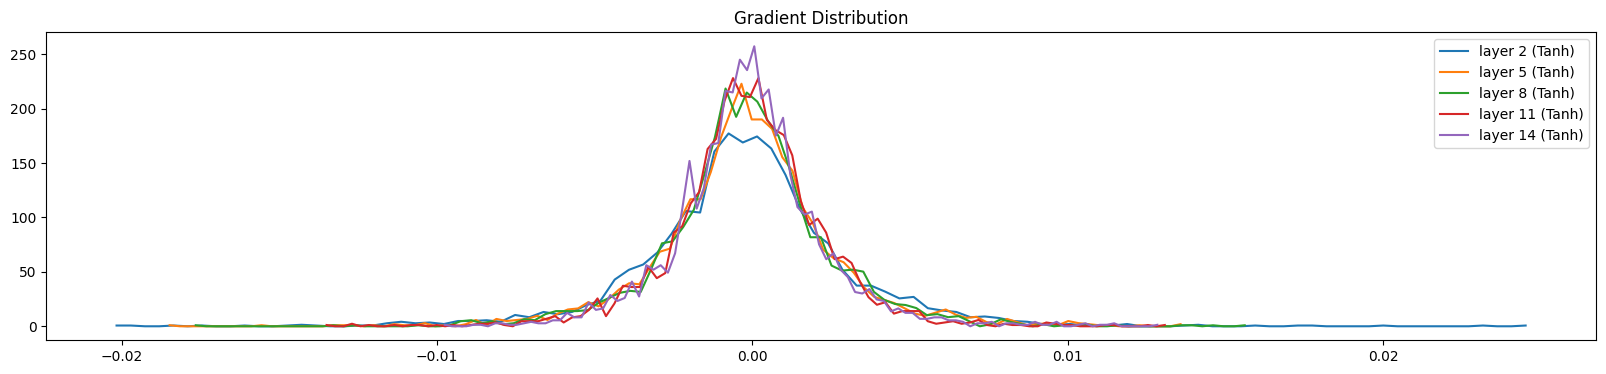

In [104]:
plt.figure(figsize=(20, 4))
legends = []
for i, layer in enumerate(Layers[:-1]):    # excludes the output layer
    if isinstance(layer, Tanh):
        t = layer.out.grad
        print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__})')
plt.legend(legends);
plt.title('Gradient Distribution')

weight   (27, 10) | mean +0.000000 | std 8.877829e-03 | grad:data ratio 8.868806e-03
weight  (30, 100) | mean +0.000312 | std 7.960688e-03 | grad:data ratio 2.546967e-02
weight (100, 100) | mean -0.000029 | std 6.509271e-03 | grad:data ratio 3.893744e-02
weight (100, 100) | mean +0.000062 | std 5.662999e-03 | grad:data ratio 3.357700e-02
weight (100, 100) | mean -0.000022 | std 5.364174e-03 | grad:data ratio 3.196108e-02
weight (100, 100) | mean -0.000043 | std 5.171619e-03 | grad:data ratio 3.080450e-02
weight  (100, 27) | mean +0.000210 | std 9.640642e-03 | grad:data ratio 5.784655e-02


Text(0.5, 1.0, 'Weights Gradient Distribution')

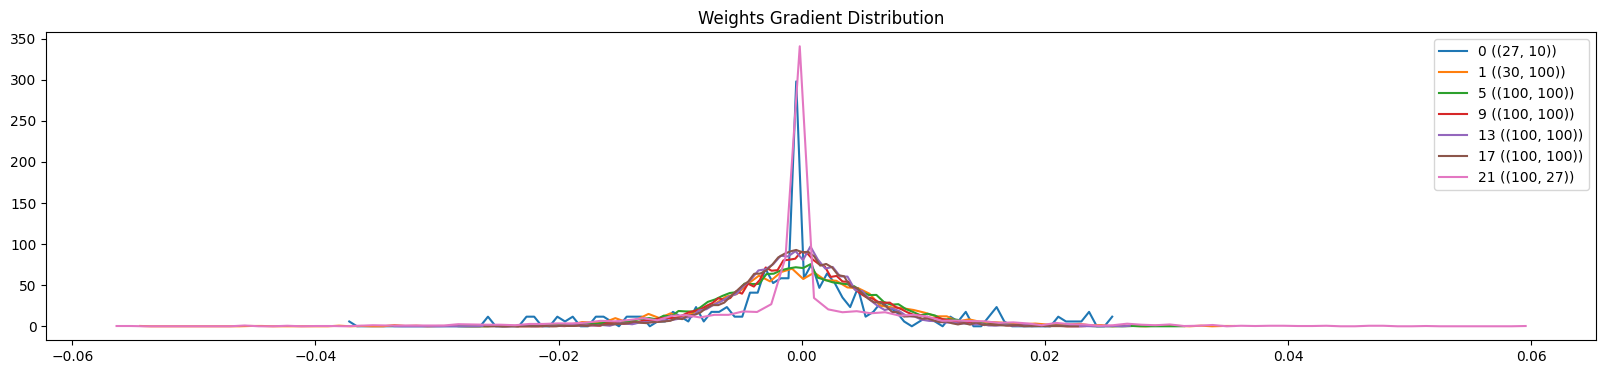

In [105]:
# Parameters
plt.figure(figsize=(20, 4))
legends = []
for i, p in enumerate(parameters):
    t = p.grad
    if p.ndim == 2:
        print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std()/p.std()))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'{i} ({tuple(p.shape)})')
plt.legend(legends);
plt.title('Weights Gradient Distribution')

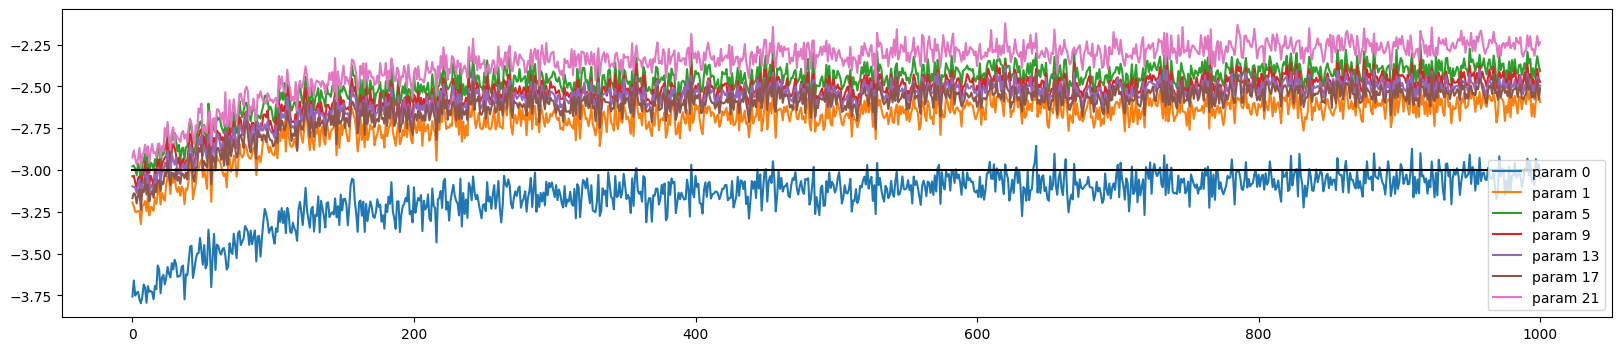

In [106]:
# Parameters (this should be viewed over time like after 1000 updates)
plt.figure(figsize=(20, 4))
legends = []
for i, p in enumerate(parameters):
    if p.ndim == 2:
        # print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std()/p.std()))
        # hy, hx = torch.histogram(t, density=True)
        # plt.plot(hx[:-1].detach(), hy.detach())
        plt.plot([ud[j][i] for j in range(len(ud))])
        legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k')    # these ratios should be ~ 1e-3
plt.legend(legends);
